**Train Random Forest Model**

1. import Python packages and training data

In [2]:
# adding required libraries
import pandas as pd
import numpy as np

In [3]:
# read data from file
df = pd.read_csv('../data/raw/NBA_train.csv')

2. Prepare the dataset for model training

In [4]:
# split data into feature and target
x = df.drop(['Id', 'TARGET_5Yrs'], axis=1)# drop the ID field
y = df[['TARGET_5Yrs']]
y.head()

,TARGET_5Yrs
0,1
1,1
2,1
3,1
4,1


In [5]:
# split the dataset into training and testing set
from sklearn.model_selection import train_test_split
x_data, x_test, y_data, y_test = train_test_split(x, y, test_size=0.2, random_state=8)

In [5]:
# check the outcome of the splitted data
y_data.shape

(6400, 1)

In [6]:
y_data.value_counts(normalize=True)

TARGET_5Yrs
1              0.832187
0              0.167813
Name: proportion, dtype: float64

3. Set up baseline model

In [6]:
# find the most occuring value and use it as base model
y_mode = y_data.mode()
y_shape = (len(x_data), 1)
y_base = np.full(y_shape, y_mode)

In [7]:
# calculate the accuracy score of the base model
from sklearn.metrics import accuracy_score
accuracy_score(y_data, y_base)

0.8321875

4. Train Extra Tree model

In [8]:
from sklearn.ensemble  import ExtraTreesClassifier
et_model = ExtraTreesClassifier(n_estimators=100, random_state=8)
et_model.fit(x_data, y_data.values.ravel())

ExtraTreesClassifier(random_state=8)

In [9]:
print(et_model.score(x_data, y_data))
print(et_model.score(x_test, y_test))

1.0
0.84


5. Perform grid search for optimised parameters

In [12]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid_et = {
    'n_estimators': [100, 200, 500],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [4, 8, 16],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the RandomForestClassifier
et_model = ExtraTreesClassifier(random_state=8)

# Initialize GridSearchCV
grid_search_et = GridSearchCV(estimator=et_model, param_grid=param_grid_et, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search_et.fit(x_data, y_data.values.ravel())

# Get the best parameters
best_params = grid_search_et.best_params_
print(f"Best parameters found: {best_params}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters found: {'max_depth': 8, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 100}


In [13]:
# Train a new Random Forest model with the best parameters
et_model = ExtraTreesClassifier(**best_params, random_state=8)
et_model.fit(x_data, y_data.values.ravel())

ExtraTreesClassifier(max_depth=8, max_features=None, random_state=8)

5. Check feature importance

In [15]:
# get feature importance
feature_importance = et_model.feature_importances_

# create a dataframe for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': x.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# display the feature importance
print(feature_importance_df)

    Feature  Importance
0        GP    0.252802
5       FG%    0.074942
9       FTM    0.063954
12     OREB    0.055065
14      REB    0.054794
1       MIN    0.048656
3       FGM    0.046679
10      FTA    0.043827
13     DREB    0.040347
2       PTS    0.040080
17      BLK    0.037292
11      FT%    0.034403
18      TOV    0.034215
6   3P Made    0.031177
8       3P%    0.029355
15      AST    0.028828
16      STL    0.028263
7       3PA    0.028068
4       FGA    0.027250


In [16]:
print(et_model.score(x_data, y_data))
print(et_model.score(x_test, y_test))

0.85078125
0.84


6. Exam the model

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

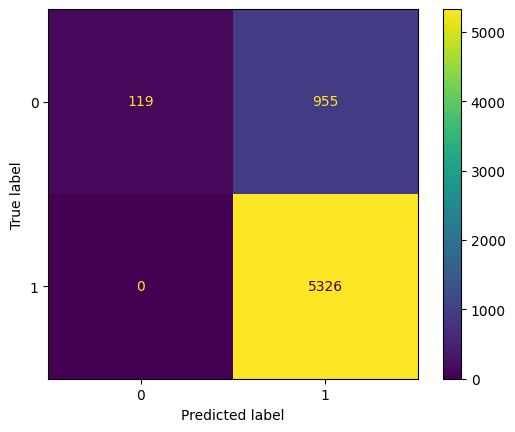

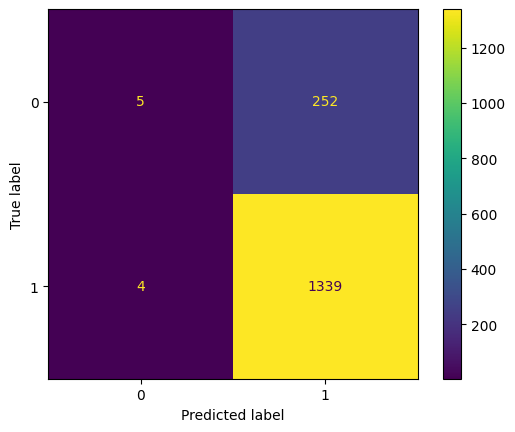

In [20]:
ConfusionMatrixDisplay.from_estimator(et_model, x_data, y_data)
ConfusionMatrixDisplay.from_estimator(et_model, x_test, y_test)

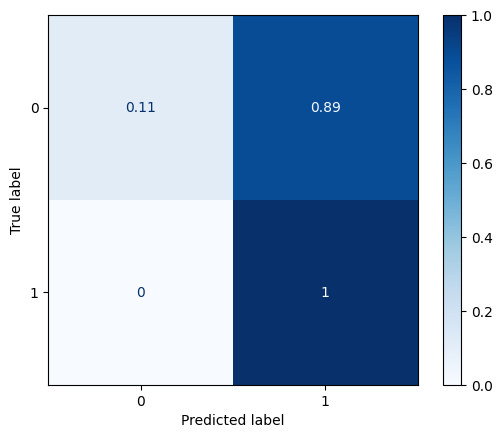

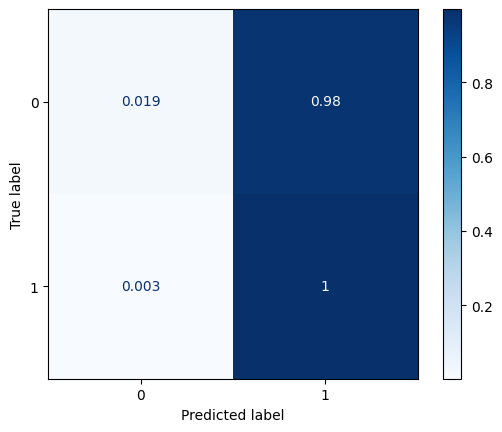

In [21]:
ConfusionMatrixDisplay.from_estimator(et_model, x_data, y_data, cmap=plt.cm.Blues, normalize='true')
ConfusionMatrixDisplay.from_estimator(et_model, x_test, y_test, cmap=plt.cm.Blues, normalize='true')

6. Conclusion
This is a better model compare to SVM model, but the accuracy is not high enough. 

7. Export Model

In [22]:
import joblib

# Export the Random Forest model
joblib.dump(et_model, '../models/et_model.pkl')

['../models/et_model.pkl']